In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
try:
    from tensorflow import keras
    from tensorflow.keras import layers, callbacks
except ImportError:
    import keras
    from keras import layers, callbacks
import warnings
warnings.filterwarnings('ignore')

import random

import keras_tuner as kt

In [2]:
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [3]:
TARGETS = ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
TEMPORAL_FEATURES = ['hour', 'is_day', 'hour_sin', 'hour_cos', 'dow', 'dow_sin', 
                     'dow_cos', 'is_holiday', 'is_weekend', 'lockdown_code']

LAGS = [6, 12, 24]

In [4]:
train_df = pd.read_csv("../data/train_features.csv")
test_df = pd.read_csv("../data/test_features_to_predict.csv")


In [5]:

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

Train shape: (40991, 213)
Test shape: (504, 208)


In [6]:
print("\nPreparing training data...")
# Identify all lag/roll columns (anything with lag_ or roll_)
all_cols = train_df.columns.tolist()
lag_roll_cols = [c for c in all_cols if 'lag_' in c or 'roll_' in c]
feature_cols = lag_roll_cols + TEMPORAL_FEATURES

print(f"Using {len(feature_cols)} features for training")
print(f"  - Lag/Roll features: {len(lag_roll_cols)}")
print(f"Targets: {TARGETS}")

# Remove rows with NaN in features or targets
train_clean = train_df[feature_cols + TARGETS].dropna()
print(f"Train samples after removing NaNs: {len(train_clean)}")

X_train_full = train_clean[feature_cols].values
Y_train_full = train_clean[TARGETS].values


Preparing training data...
Using 204 features for training
  - Lag/Roll features: 194
Targets: ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25']
Train samples after removing NaNs: 40991


In [7]:
split_idx = int(0.85 * len(X_train_full))
X_train = X_train_full[:split_idx]
Y_train = Y_train_full[:split_idx]
X_val = X_train_full[split_idx:]
Y_val = Y_train_full[split_idx:]

print(f"\nTrain samples: {X_train.shape[0]}")
print(f"Val samples: {X_val.shape[0]}")


Train samples: 34842
Val samples: 6149


In [8]:
print("\nScaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Scale targets per pollutant
target_scalers = {}
Y_train_scaled = np.zeros_like(Y_train, dtype=np.float32)
Y_val_scaled = np.zeros_like(Y_val, dtype=np.float32)

for i, target in enumerate(TARGETS):
    scaler_t = StandardScaler()
    Y_train_scaled[:, i] = scaler_t.fit_transform(Y_train[:, i:i+1]).ravel()
    Y_val_scaled[:, i] = scaler_t.transform(Y_val[:, i:i+1]).ravel()
    target_scalers[target] = scaler_t


n_features = X_train_scaled.shape[1]
n_targets = len(TARGETS)


Scaling features...


In [9]:
# ============================================================================
# DEFINE MODEL BUILDER FOR KERAS TUNER
# ============================================================================
def build_model(hp):
    """
    Build model with hyperparameters to tune
    """
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(n_features,)))
    
    # Tune number of layers (2-4 hidden layers)
    n_layers = hp.Int('n_layers', min_value=2, max_value=4, step=1)
    
    for i in range(n_layers):
        # Tune units in each layer
        units = hp.Int(f'units_layer_{i}', 
                       min_value=32, 
                       max_value=256, 
                       step=32)
        
        # Tune activation function
        activation = hp.Choice('activation', ['relu', 'elu', 'leaky_relu'])
        
        if activation == 'leaky_relu':
            model.add(layers.Dense(units))
            model.add(layers.LeakyReLU(alpha=0.1))
        else:
            model.add(layers.Dense(units, activation=activation))
        
        # Tune dropout rate
        dropout_rate = hp.Float(f'dropout_{i}', 
                                min_value=0.0, 
                                max_value=0.5, 
                                step=0.1)
        if dropout_rate > 0:
            model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(n_targets))
    
    # Tune learning rate
    learning_rate = hp.Float('learning_rate', 
                             min_value=1e-4, 
                             max_value=1e-2, 
                             sampling='log')
    
    # Tune optimizer
    optimizer_choice = hp.Choice('optimizer', ['adam', 'adamw'])
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = keras.optimizers.AdamW(learning_rate=learning_rate)
    
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
    )
    
    return model

# ============================================================================
# KERAS TUNER SEARCH
# ============================================================================
print("\n" + "="*70)
print("HYPERPARAMETER TUNING WITH KERAS TUNER")
print("="*70)

# Choose tuner - Hyperband is fastest and often best
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective('val_mae', direction='min'),
    max_epochs=100,
    factor=3,
    hyperband_iterations=2,
    directory='tuner_results',
    project_name='air_quality_ffnn',
    overwrite=True,
    seed=SEED
)

# Alternative: Bayesian Optimization (slower but sometimes better)
# tuner = kt.BayesianOptimization(
#     build_model,
#     objective=kt.Objective('val_mae', direction='min'),
#     max_trials=30,
#     directory='tuner_results',
#     project_name='air_quality_ffnn',
#     overwrite=True,
#     seed=SEED
# )

print("\nSearch space summary:")
tuner.search_space_summary()

# Callbacks for tuning
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=0
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-6,
    verbose=0
)

# Run the search
print("\nStarting hyperparameter search...")
print("This may take a while (10-30 minutes depending on your hardware)...")

tuner.search(
    X_train_scaled, Y_train_scaled,
    validation_data=(X_val_scaled, Y_val_scaled),
    epochs=100,
    batch_size=128,  # You can also tune this if you want
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# ============================================================================
# GET BEST MODEL AND RESULTS
# ============================================================================
print("\n" + "="*70)
print("TUNING RESULTS")
print("="*70)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n🏆 Best Hyperparameters:")
print(f"  Number of layers: {best_hps.get('n_layers')}")
for i in range(best_hps.get('n_layers')):
    print(f"  Layer {i+1} units: {best_hps.get(f'units_layer_{i}')}")
    print(f"  Layer {i+1} dropout: {best_hps.get(f'dropout_{i}'):.2f}")
print(f"  Activation: {best_hps.get('activation')}")
print(f"  Learning rate: {best_hps.get('learning_rate'):.6f}")
print(f"  Optimizer: {best_hps.get('optimizer')}")

# Build and train best model with more epochs
print("\n\nTraining best model with full epochs...")
best_model = tuner.hypermodel.build(best_hps)

early_stop_final = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history = best_model.fit(
    X_train_scaled, Y_train_scaled,
    validation_data=(X_val_scaled, Y_val_scaled),
    epochs=150,
    batch_size=128,
    callbacks=[early_stop_final],
    verbose=1
)


Trial 178 Complete [00h 00m 14s]
val_mae: 0.3678438067436218

Best val_mae So Far: 0.22852040827274323
Total elapsed time: 00h 28m 29s

Search: Running Trial #179

Value             |Best Value So Far |Hyperparameter
4                 |2                 |n_layers
192               |192               |units_layer_0
relu              |elu               |activation
0                 |0.2               |dropout_0
192               |224               |units_layer_1
0.3               |0.1               |dropout_1
0.00092718        |0.00032188        |learning_rate
adamw             |adam              |optimizer
192               |32                |units_layer_2
0.3               |0.3               |dropout_2
128               |128               |units_layer_3
0.4               |0.2               |dropout_3
4                 |100               |tuner/epochs
0                 |34                |tuner/initial_epoch
3                 |4                 |tuner/bracket
0                 |4      

KeyboardInterrupt: 

In [10]:
# ============================================================================
# GET BEST MODEL AND RESULTS
# ============================================================================
print("\n" + "="*70)
print("TUNING RESULTS")
print("="*70)

# Get best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("\n🏆 Best Hyperparameters:")
print(f"  Number of layers: {best_hps.get('n_layers')}")
for i in range(best_hps.get('n_layers')):
    print(f"  Layer {i+1} units: {best_hps.get(f'units_layer_{i}')}")
    print(f"  Layer {i+1} dropout: {best_hps.get(f'dropout_{i}'):.2f}")
print(f"  Activation: {best_hps.get('activation')}")
print(f"  Learning rate: {best_hps.get('learning_rate'):.6f}")
print(f"  Optimizer: {best_hps.get('optimizer')}")

# Build and train best model with more epochs
print("\n\nTraining best model with full epochs...")
best_model = tuner.hypermodel.build(best_hps)

early_stop_final = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

history = best_model.fit(
    X_train_scaled, Y_train_scaled,
    validation_data=(X_val_scaled, Y_val_scaled),
    epochs=150,
    batch_size=128,
    callbacks=[early_stop_final],
    verbose=1
)



TUNING RESULTS

🏆 Best Hyperparameters:
  Number of layers: 2
  Layer 1 units: 192
  Layer 1 dropout: 0.20
  Layer 2 units: 224
  Layer 2 dropout: 0.10
  Activation: elu
  Learning rate: 0.000322
  Optimizer: adam


Training best model with full epochs...
Epoch 1/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.4981 - mae: 0.5084 - val_loss: 0.2476 - val_mae: 0.3219
Epoch 2/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3168 - mae: 0.3985 - val_loss: 0.2240 - val_mae: 0.3008
Epoch 3/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2798 - mae: 0.3697 - val_loss: 0.2089 - val_mae: 0.2848
Epoch 4/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2582 - mae: 0.3522 - val_loss: 0.2020 - val_mae: 0.2772
Epoch 5/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2455 - mae: 0.3408 - val_loss: 0.1970 - val_mae: 0.2718
Epoch 6/150
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2356 - mae: 0.3324 - val_loss: 0.1924 - val_mae: 0.2668
Epoch 7/150
273/273 ━━━━━━━━━

In [11]:
# ============================================================================
# EVALUATE BEST MODEL
# ============================================================================
print("\n" + "="*70)
print("BEST MODEL VALIDATION RESULTS")
print("="*70)

Y_val_pred_scaled = best_model.predict(X_val_scaled, verbose=0)
mae_per_pollutant = []

print("\nValidation MAE per pollutant:")
for i, target in enumerate(TARGETS):
    y_pred_unscaled = target_scalers[target].inverse_transform(Y_val_pred_scaled[:, i:i+1])
    mae = mean_absolute_error(Y_val[:, i], y_pred_unscaled)
    mae_per_pollutant.append(mae)
    print(f"  {target}: {mae:.4f}")

final_score_val = np.mean(mae_per_pollutant)
print(f"\n🎯 Final Validation Score (avg MAE): {final_score_val:.4f}")

# Compare with top 3 models
print("\n\nTop 3 Models Comparison:")
best_trials = tuner.oracle.get_best_trials(num_trials=3)
for i, trial in enumerate(best_trials, 1):
    print(f"\nModel {i}:")
    print(f"  Val MAE: {trial.metrics.get_last_value('val_mae'):.4f}")
    print(f"  Val Loss: {trial.metrics.get_last_value('val_loss'):.4f}")


BEST MODEL VALIDATION RESULTS

Validation MAE per pollutant:
  valeur_NO2: 3.8320
  valeur_CO: 0.0224
  valeur_O3: 6.2741
  valeur_PM10: 2.6700
  valeur_PM25: 1.7360

🎯 Final Validation Score (avg MAE): 2.9069


Top 3 Models Comparison:

Model 1:
  Val MAE: 0.2285
  Val Loss: 0.1575

Model 2:
  Val MAE: 0.2288
  Val Loss: 0.1570

Model 3:
  Val MAE: 0.2332
  Val Loss: 0.1591



✅ Best model saved to best_tuned_model.keras


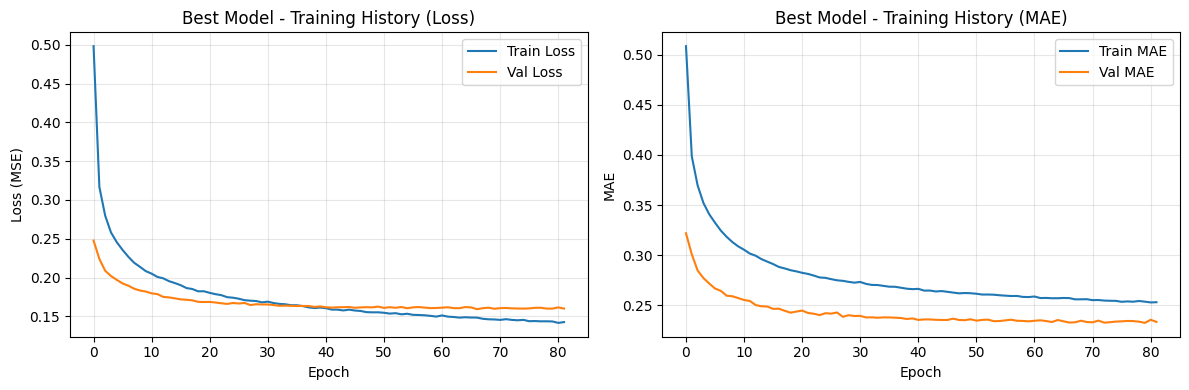

✅ Training history saved to tuned_model_history.png


In [12]:
# ============================================================================
# SAVE BEST MODEL AND MAKE PREDICTIONS
# ============================================================================
best_model.save('best_tuned_model.keras')
print("\n✅ Best model saved to best_tuned_model.keras")

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Best Model - Training History (Loss)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Best Model - Training History (MAE)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('tuned_model_history.png', dpi=100, bbox_inches='tight')
plt.show()
print("✅ Training history saved to tuned_model_history.png")

In [18]:
# ============================================================================
# AUTO-REGRESSIVE TEST PREDICTION
# ============================================================================
print("\n" + "="*70)
print("AUTO-REGRESSIVE TEST PREDICTION")
print("="*70)

# Step 1: Parse lag and rolling column names
print("\nStep 1: Parsing lag and rolling feature structure...")
print(f"Sample feature columns: {feature_cols[:10]}")

lag_info = {}  # {feature_name: {lag_hours: col_index}}
roll_info = {}  # {(feature_name, stat, window): col_index}

for idx, col in enumerate(feature_cols):
    if col in TEMPORAL_FEATURES:
        continue
    
    # Parse LAG features: format is "valeur_NO2_lag_6"
    if '_lag_' in col:
        parts = col.split('_lag_')
        if len(parts) == 2:
            feature_name = parts[0]
            try:
                lag_hours = int(parts[1])
                if feature_name not in lag_info:
                    lag_info[feature_name] = {}
                lag_info[feature_name][lag_hours] = idx
            except ValueError:
                print(f"Warning: Could not parse lag value from: {col}")
                continue
    
    # Parse ROLLING features: format is "valeur_NO2_roll_mean_6"
    elif '_roll_' in col:
        parts = col.split('_roll_')
        if len(parts) == 2:
            feature_name = parts[0]
            stat_and_window = parts[1].split('_')
            
            if len(stat_and_window) >= 2:
                try:
                    window = int(stat_and_window[-1])
                    stat = '_'.join(stat_and_window[:-1])
                    
                    key = (feature_name, stat, window)
                    roll_info[key] = idx
                except ValueError:
                    print(f"Warning: Could not parse rolling window from: {col}")
                    continue

print(f"\nFound lag features for: {list(lag_info.keys())[:10]}")
print(f"Found {len(roll_info)} rolling window features")

# Step 2: Initialize history buffer
print("\nStep 2: Initializing history buffer...")

max_lag = 0
if lag_info:
    max_lag = max([max(lags.keys()) for lags in lag_info.values()])

max_window = 0
if roll_info:
    max_window = max([key[2] for key in roll_info.keys()])

history_length = max(max_lag, max_window) + 1
print(f"Max lag needed: {max_lag} hours")
print(f"Max rolling window: {max_window} hours")
print(f"History buffer length: {history_length} hours")

# Initialize history
last_train = train_df.iloc[-history_length:].copy()
target_history = last_train[TARGETS].values.tolist()

feature_value_history = {}
for feature_name in lag_info.keys():
    if feature_name in last_train.columns:
        feature_value_history[feature_name] = last_train[feature_name].values.tolist()
    else:
        feature_value_history[feature_name] = [0.0] * history_length

print(f"Initialized history with last {history_length} training samples")

# Step 3: Helper function
def compute_features_from_history(target_history, feature_value_history, test_row, 
                                   feature_cols, lag_info, roll_info):
    features = np.zeros(len(feature_cols))
    
    for idx, col in enumerate(feature_cols):
        if col in TEMPORAL_FEATURES:
            if col in test_row.index:
                features[idx] = test_row[col]
            else:
                features[idx] = 0
            continue
        
        # Handle lag features
        if '_lag_' in col:
            parts = col.split('_lag_')
            if len(parts) == 2:
                feature_name = parts[0]
                try:
                    lag_hours = int(parts[1])
                    
                    if feature_name in TARGETS:
                        target_idx = TARGETS.index(feature_name)
                        if lag_hours <= len(target_history):
                            features[idx] = target_history[-lag_hours][target_idx]
                    elif feature_name in feature_value_history:
                        if lag_hours <= len(feature_value_history[feature_name]):
                            features[idx] = feature_value_history[feature_name][-lag_hours]
                except (ValueError, IndexError):
                    features[idx] = 0
        
        # Handle rolling features
        elif '_roll_' in col:
            parts = col.split('_roll_')
            if len(parts) == 2:
                feature_name = parts[0]
                stat_and_window = parts[1].split('_')
                
                if len(stat_and_window) >= 2:
                    try:
                        window = int(stat_and_window[-1])
                        stat = '_'.join(stat_and_window[:-1])
                        
                        values = []
                        if feature_name in TARGETS:
                            target_idx = TARGETS.index(feature_name)
                            values = [row[target_idx] for row in target_history[-window:]]
                        elif feature_name in feature_value_history:
                            values = feature_value_history[feature_name][-window:]
                        
                        if len(values) > 0:
                            if stat == 'mean':
                                features[idx] = np.mean(values)
                            elif stat == 'std':
                                features[idx] = np.std(values)
                            elif stat == 'min':
                                features[idx] = np.min(values)
                            elif stat == 'max':
                                features[idx] = np.max(values)
                    except (ValueError, IndexError):
                        features[idx] = 0
    
    return features

# Step 4: Iterative prediction
print("\nStep 4: Predicting test samples iteratively...")
test_predictions = []

for idx in range(len(test_df)):
    if idx % 500 == 0:
        print(f"  Predicting sample {idx}/{len(test_df)}...")
    
    test_row = test_df.iloc[idx]
    
    features = compute_features_from_history(
        target_history, feature_value_history, test_row, 
        feature_cols, lag_info, roll_info
    )
    
    features_scaled = scaler.transform(features.reshape(1, -1))
    pred_scaled = best_model.predict(features_scaled, verbose=0)
    
    pred_unscaled = np.zeros(n_targets)
    for i, target in enumerate(TARGETS):
        pred_unscaled[i] = target_scalers[target].inverse_transform(
            pred_scaled[:, i:i+1]
        ).ravel()[0]
    
    test_predictions.append(pred_unscaled)
    
    # Update history
    target_history.append(pred_unscaled.tolist())
    
    for feature_name in feature_value_history.keys():
        if feature_name not in TARGETS:
            feature_value_history[feature_name].append(
                feature_value_history[feature_name][-1]
            )
    
    if len(target_history) > history_length:
        target_history.pop(0)
    for feature_name in feature_value_history.keys():
        if len(feature_value_history[feature_name]) > history_length:
            feature_value_history[feature_name].pop(0)

test_predictions = np.array(test_predictions)
print(f"✅ Test predictions shape: {test_predictions.shape}")



AUTO-REGRESSIVE TEST PREDICTION

Step 1: Parsing lag and rolling feature structure...
Sample feature columns: ['valeur_NO2_lag_6', 'valeur_NO2_lag_12', 'valeur_NO2_lag_24', 'valeur_NO2_roll_mean_6', 'valeur_NO2_roll_std_6', 'valeur_NO2_roll_mean_24', 'valeur_NO2_roll_std_24', 'valeur_CO_lag_6', 'valeur_CO_lag_12', 'valeur_CO_lag_24']

Found lag features for: ['valeur_NO2', 'valeur_CO', 'valeur_O3', 'valeur_PM10', 'valeur_PM25', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m', 'apparent_temperature', 'pressure_msl']
Found 110 rolling window features

Step 2: Initializing history buffer...
Max lag needed: 24 hours
Max rolling window: 24 hours
History buffer length: 25 hours
Initialized history with last 25 training samples

Step 4: Predicting test samples iteratively...
  Predicting sample 0/504...
  Predicting sample 500/504...
✅ Test predictions shape: (504, 5)


In [20]:
# ============================================================================
# CREATE SUBMISSION
# ============================================================================
print("\nCreating autoregressive submission file...")
submission_ar = pd.DataFrame()
submission_ar['id'] = test_df['id'].values
for i, target in enumerate(TARGETS):
    submission_ar[target] = test_predictions[:, i]

submission_ar.to_csv('ffnn_autoregressive_tuned_submission.csv', index=False)
print("✅ Autoregressive submission saved to ffnn_autoregressive_submission.csv")
print(f"\nSubmission preview:\n{submission_ar.head()}")
print(f"\nSubmission shape: {submission_ar.shape}")



Creating autoregressive submission file...
✅ Autoregressive submission saved to ffnn_autoregressive_submission.csv

Submission preview:
              id  valeur_NO2  valeur_CO  valeur_O3  valeur_PM10  valeur_PM25
0  2024-09-03 23   29.343670   0.481611  66.369408    59.428238    35.219284
1  2024-09-04 00   31.406080   0.446089  64.676086    53.869518    32.025383
2  2024-09-04 01   32.508995   0.444822  65.746933    54.945435    32.842903
3  2024-09-04 02   32.904800   0.441438  68.193993    56.790497    34.194698
4  2024-09-04 03   32.943020   0.441198  72.338768    59.341019    36.326530

Submission shape: (504, 6)


In [13]:
# ============================================================================
# PREPARE TEST DATA - ROLLING AVERAGE APPROACH
# ============================================================================
print("\nPreparing test data with rolling lag features...")
# Get last 24 rows of train to use for averaging (more realistic than single row)
last_24_rows = train_df.iloc[-24:].copy()
print(f"feature_cols length: {len(feature_cols)}")
print(f"Using last 24 rows of train for feature averaging")
# Build test features: average features from last 24 train rows, update temporal from test_df
test_features_list = []
for idx in range(len(test_df)):
    test_row = test_df.iloc[idx].copy()

    # Average each feature across last 24 train rows
    base_features = []
    for col in feature_cols:
        if col in last_24_rows.columns:
            # For temporal features, we'll override later; for others, take mean
            if col not in TEMPORAL_FEATURES:
                feat_val = float(last_24_rows[col].mean())
            else:
                feat_val = float(last_24_rows[col].iloc[-1])  # Use last value for temporal
            base_features.append(feat_val)
        else:
            base_features.append(0.0)

    base_features = np.array(base_features)

    # Update temporal features from test_df (these change for each test row)
    for i, col in enumerate(feature_cols):
        if col in TEMPORAL_FEATURES and col in test_row.index:
            base_features[i] = float(test_row[col])

    test_features_list.append(base_features)
X_test = np.array(test_features_list)
print(f"Test features shape: {X_test.shape}")
print(f"Expected features: {n_features}")
# Scale test features
X_test_scaled = scaler.transform(X_test)

print("\nPredicting on test set...")
Y_test_pred_scaled = best_model.predict(X_test_scaled, verbose=0)
# Inverse scale predictions
Y_test_pred = np.zeros_like(Y_test_pred_scaled)
for i, target in enumerate(TARGETS):
    Y_test_pred[:, i] = target_scalers[target].inverse_transform(Y_test_pred_scaled[:, i:i+1]).ravel()
print(f"Test predictions shape: {Y_test_pred.shape}")


Preparing test data with rolling lag features...
feature_cols length: 204
Using last 24 rows of train for feature averaging
Test features shape: (504, 204)
Expected features: 204

Predicting on test set...
Test predictions shape: (504, 5)


In [14]:
print("\nCreating submission file...")
submission = pd.DataFrame()
submission['id'] = test_df['id'].values
for i, target in enumerate(TARGETS):
    submission[target] = Y_test_pred[:, i]
submission.to_csv('ffnn_tuned_submission.csv', index=False)
print("✅ Submission tuned and saved to submission.csv")
print(f"\nSubmission preview:\n{submission.head()}")
print(f"\nSubmission shape: {submission.shape}")




Creating submission file...
✅ Submission tuned and saved to submission.csv

Submission preview:
              id  valeur_NO2  valeur_CO  valeur_O3  valeur_PM10  valeur_PM25
0  2024-09-03 23   11.431797   0.147184  49.796509     7.398799     3.252525
1  2024-09-04 00   10.105369   0.141766  50.754623     8.036657     3.778835
2  2024-09-04 01   10.861167   0.139724  49.799408     7.862419     3.478698
3  2024-09-04 02   12.494232   0.141220  47.995415     7.959749     3.322699
4  2024-09-04 03   14.745300   0.145918  45.651707     8.300172     3.311071

Submission shape: (504, 6)


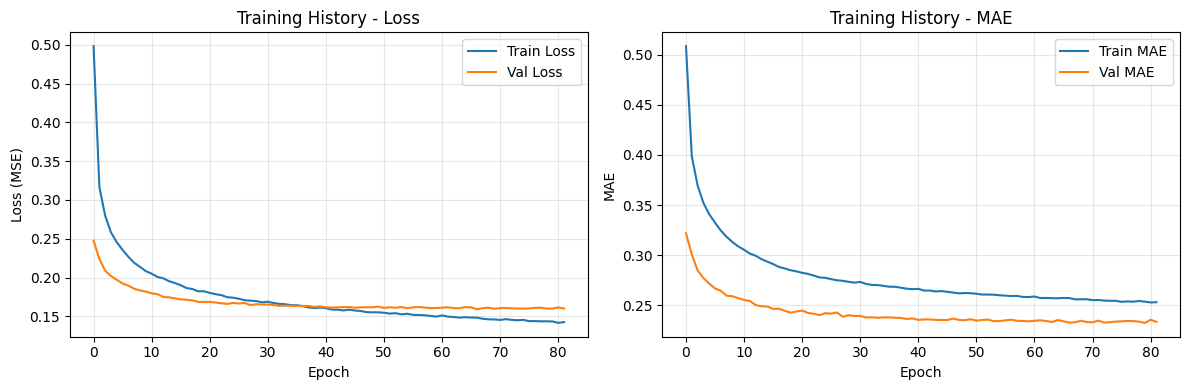

✅ Training history plot saved to training_history.png


In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.title('Training History - Loss')
plt.grid(True, alpha=0.3)
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training History - MAE')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_history.png', dpi=100, bbox_inches='tight')
plt.show()
print("✅ Training history plot saved to training_history.png")

In [16]:
# ============================================================================
# SANITY CHECK
# ============================================================================
print("\n" + "="*70)
print("SANITY CHECK - Prediction Statistics")
print("="*70)
for i, target in enumerate(TARGETS):
    print(f"\n{target}:")
    print(f"  Train mean: {train_df[target].mean():.2f}")
    print(f"  Test predictions mean: {Y_test_pred[:, i].mean():.2f}")
    print(f"  Test predictions range: [{Y_test_pred[:, i].min():.2f}, {Y_test_pred[:, i].max():.2f}]")


SANITY CHECK - Prediction Statistics

valeur_NO2:
  Train mean: 22.34
  Test predictions mean: 15.32
  Test predictions range: [9.67, 22.50]

valeur_CO:
  Train mean: 0.21
  Test predictions mean: 0.16
  Test predictions range: [0.14, 0.19]

valeur_O3:
  Train mean: 50.65
  Test predictions mean: 47.84
  Test predictions range: [39.51, 53.83]

valeur_PM10:
  Train mean: 18.43
  Test predictions mean: 9.59
  Test predictions range: [7.20, 11.50]

valeur_PM25:
  Train mean: 11.00
  Test predictions mean: 4.23
  Test predictions range: [2.94, 6.39]


In [17]:
# Boost PM predictions by 10-20% if needed
submission_adjusted = submission.copy()
submission_adjusted['valeur_PM10'] *= 1.15  # Boost by 15%
submission_adjusted['valeur_PM25'] *= 1.20  # Boost by 20%
submission_adjusted.to_csv('tuned_adjusted_submission.csv', index=False)